**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Keep up the good work on the next sprint! :)

# Machine Learning in Business: Finding an Optimal Region for Development of New Oil Wells

OilyGiant has tasked me with using the regional data they provided to choose a location for new oil well.

Conditions:
Only linear regression is suitable for model training (the rest are not sufficiently predictable).
When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
The budget for development of 200 oil wells is 100 USD million.
One barrel of raw materials brings 4.5 USD of revenue. The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.
The data is synthetic: contract details and well characteristics are not disclosed.

Steps to choose the location:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.

I have data on oil samples from three regions. Parameters of each oil well in the region are already known. I will build a model that will help to pick the region with the highest profit margin. Finally I will analyze potential profit and risks using the Bootstrapping technique.

## Initializing

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None 
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import explained_variance_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


Import the data

In [2]:
try:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('C:/Users/hotty/Desktop/Practicum by Yandex/Projects/Machine Learning in Business/geo_data_0.csv')
    geo_data_1 = pd.read_csv('C:/Users/hotty/Desktop/Practicum by Yandex/Projects/Machine Learning in Business/geo_data_1.csv')
    geo_data_2 = pd.read_csv('C:/Users/hotty/Desktop/Practicum by Yandex/Projects/Machine Learning in Business/geo_data_2.csv')
print('Data has been read correctly!')

Data has been read correctly!


I will make some helper functions to get preliminary data on the condition of the data

In [3]:

def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
def get_info(df):
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

In [4]:
# study the general information about the dataset 
print('General information about the dataframe')
get_info(geo_data_0)
get_info(geo_data_1)
get_info(geo_data_2)

General information about the dataframe
----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99990
top,A5aEY
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.


----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,LHZR0
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.


----------------------------------------------------------------------------------------------------
Head:



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


----------------------------------------------------------------------------------------------------


,id
count,100000
unique,99996
top,VF7Jo
freq,2



Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(100000, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.




The condition of the data is good, overall we have no NaN and no duplicated rows. This is excellent so I will move forward with my analysis.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, the data was loaded and inspected!

</div>

## Splitting the data and testing models
We split the data into 75% training and 25% testing set. We then fit a linear model using the training data. Once the model is trained, we use it for prediction to predict the volume of reserves in the oil well (thousand barrels).

In [5]:
# function to train a model and make predictions
def train_test_predict(df):
  
    df = df.drop(['id'], axis=1)

    target = df['product']
    features = df.drop(['product'], axis=1)

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345
    )
    
    scaler = StandardScaler()
    scaler.fit(features_train)
   
    features_train = scaler.transform(features_train)
    features_valid  = scaler.transform(features_valid)

    model = LinearRegression()
    model.fit(features_train, target_train) 
    valid_predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    return valid_predictions, target_valid


def reg_metrics(y_test, y_pred):
    print('Mean absolute error: %.2f' % mean_absolute_error(y_test, y_pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, y_pred))
    print('Mean squared error: %.3f' % mean_squared_error(y_test, y_pred))
    print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.4f' % r2_score(y_test, y_pred)) # coeff. of determination
    forecast_err = np.array(y_test) - np.array(y_pred)
    print('Forecast bias: %.4f' % (np.sum(forecast_err) * 1.0/len(y_pred)))

#### Region 1 - geo_data_0

In [6]:
valid_predictions_0, target_valid_0 = train_test_predict(geo_data_0)

reg_metrics(valid_predictions_0, target_valid_0)

Mean absolute error: 30.92
Explained variance score: -1.6286
Mean squared error: 1412.213
RMSE: 37.5794
Variance score: -1.6291
Forecast bias: 0.5140


In [7]:
print('Average volume of reserves: %.2f' % target_valid_0.mean())
print('The average volume of predicted reserves is: %.2f' % valid_predictions_0.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(valid_predictions_0, target_valid_0)))

Average volume of reserves: 92.08
The average volume of predicted reserves is: 92.59
The model's RMSE is : 37.5794


#### Region 2 - geo_data_1

In [8]:
valid_predictions_1, target_valid_1 = train_test_predict(geo_data_1)

reg_metrics(valid_predictions_1, target_valid_1)

Mean absolute error: 0.72
Explained variance score: 0.9996
Mean squared error: 0.798
RMSE: 0.8931
Variance score: 0.9996
Forecast bias: 0.0054


In [9]:
print('Average volume of reserves: %.2f' % target_valid_1.mean())
print('The average volume of predicted reserves is: %.2f' % valid_predictions_1.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(valid_predictions_1, target_valid_1)))

Average volume of reserves: 68.72
The average volume of predicted reserves is: 68.73
The model's RMSE is : 0.8931


#### Region 3 - geo_data_2

In [10]:
valid_predictions_2, target_valid_2 = train_test_predict(geo_data_2)

reg_metrics(valid_predictions_2, target_valid_2)

Mean absolute error: 32.79
Explained variance score: -3.0653
Mean squared error: 1602.378
RMSE: 40.0297
Variance score: -3.0653
Forecast bias: 0.0808


In [11]:
print('Average volume of reserves: %.2f' % target_valid_2.mean())
print('The average volume of predicted reserves is: %.2f' % valid_predictions_2.mean())
print("The model's RMSE is : %.4f" % np.sqrt(mean_squared_error(valid_predictions_2, target_valid_2)))

Average volume of reserves: 94.88
The average volume of predicted reserves is: 94.97
The model's RMSE is : 40.0297


### Summary:

- Region 1 - geo_data_0:
    - Regions	Average Actual Reserve (in thousands STB): 92.08	
    - Average Predicted Reserve (in thousands STB):92.59	
    - RMSE: 37.58	
    - MAE: 30.92
- Region 2 - geo_data_1:
    - Regions	Average Actual Reserve (in thousands STB):68.72	
    - Average Predicted Reserve (in thousands STB):68.73	
    - RMSE: 0.89	
    - MAE: 0.72
- Region 3 - geo_data_2:
    - Regions	Average Actual Reserve (in thousands STB):94.88	
    - Average Predicted Reserve (in thousands STB):94.97	
    - RMSE: 40.03	
    - MAE: 32.79

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, the data for each region was split into train and validation sets, the models were trained and evaluated correctly

</div>

### Conclusion
In region 1, the R2 metric is -1.62, indicating the model quality is low, the mean error for each well is 30.92 thousand barrels, and the high RMSE value of 37.58 thousand barrels, therefore there may be outliers in the data.  The model is overpredicting average reserves in region 1.

In region 2, the R2 metric is 0.9996 indicating the model quality is good. The MAE value of 0.72 thousand barrels means that the model is an adequate predictor of the reserve in this region, and the RMSE value of 0.89 thousand barrels indicates that the model is giving a prediction close to the actual reserve. 

In region 3, the R2 metric is -3.06 indicating poor model quality. The MAE value of 32.79 thousand barrels, and RMSE value of 40.03 thousand barrels indicate an overprediction of average value of reserves by the model in region 3.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions make sense!

</div>

## Prepare for profit calculation

Store key values in separate variables

In [12]:
region_points = 500 
best_region_for_profit = 200 
capital_cost = 100 * 10**6 
cost_per_bbl = 4.5 
risk_of_losses = 0.025

Calculate the volume of reserves for developing new well without losses

In [13]:
revenue = cost_per_bbl * best_region_for_profit
volume_of_reserves = capital_cost / revenue
print('The volume of reserves required to develop a new well without losses: %.2f' % volume_of_reserves, 'Stock Tank Barrels (STB).')

The volume of reserves required to develop a new well without losses: 111111.11 Stock Tank Barrels (STB).


### Summary

We calculated the volume of reserves sufficient to develop a new well without loss as 111111.11 barrels. This volume will be our baseline value.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Calculation is correct, although to make this value measured in the same units as average volumes of predicted reserves we calculated earlier, we need to divide this number by 1000. And then we get that average volume in each region is lower than required to break even. But this is only a problem if we just select the wells to develop randomly. Let's see if applying our models to select the best 200 wells from a random sample of 500 helps!

</div>

## Function for calculation of profit

In [14]:

def highest_prediction(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    print('The highest prediction value is: %.2f' % total_selected_reserves_volume_target,
          'STB or %.2f' % (total_selected_reserves_volume_target / 10**6), 'MMSTB')

def reserves_profit(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    selected_reserves_profit = total_selected_reserves_volume_target * cost_per_bbl - capital_cost
    print('The selected reserves profit is: $%.2f' % selected_reserves_profit)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The functions for profit calculation are correct

</div>

### Region with the highest values of predictions

In this section, we will look at all three regions to see which one gives the highest value of predictions

##### Region 1 - geo_data_0

In [15]:
highest_prediction(target_valid_0, valid_predictions_0, 200)

The highest prediction value is: 29601835.65 STB or 29.60 MMSTB


##### Region 2 - geo_data_1

In [16]:
highest_prediction(target_valid_1, valid_predictions_1, 200)

The highest prediction value is: 27589081.55 STB or 27.59 MMSTB


##### Region 3 - geo_data_2

In [17]:
highest_prediction(target_valid_2, valid_predictions_2, 200)

The highest prediction value is: 28245222.14 STB or 28.25 MMSTB


From the calculation on highest values of prediction, Region 1 - geo_data_0 has the highest prediction of the three regions. Region 1 - geo_data_0 has the highest estimated reserve among the three regions.

### Profit for obtained volume of reserves in each region
We look at the profit from each region

##### Region 1 - geo_data_0

In [18]:
reserves_profit(target_valid_0, valid_predictions_0, 200)

The selected reserves profit is: $33208260.43


##### Region 2 - geo_data_1

In [19]:
reserves_profit(target_valid_1, valid_predictions_1, 200)

The selected reserves profit is: $24150866.97


##### Region 3 - geo_data_2

In [20]:
reserves_profit(target_valid_2, valid_predictions_2, 200)

The selected reserves profit is: $27103499.64


The region with the highest profit is Region 1 - geo_data_0 with 33 million USD, triple our baseline for profit estimation of $11 million. We recommend OilyGiant channel more drilling activities in this region.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

While that's true, it's highly unlikely to actually attain this value, as putting the whole validation set targets/predictions as input to the profit calculation function assumes that we're selecting top 200 out of all wells, but that's not true: we're selecting from the best 200 out of 500 randomly selected wells. It would not be commercially viable to make preliminary measurements at 25000 locations :)

</div>

## Calculate risks and profit for each region

Use bootstrapping technique to find distribution of profit

In [21]:
def revenue(y_test, y_pred, count):
    highest_reserves_volume_predicted = y_pred.sort_values(ascending=False)
    selected_reserves_volume_target = y_test[highest_reserves_volume_predicted.index][:count]
    total_selected_reserves_volume_target = selected_reserves_volume_target.sum() * 1000
    selected_reserves_profit = total_selected_reserves_volume_target * cost_per_bbl - capital_cost
    return selected_reserves_profit

def bootstrapping_revenue(y_test, y_pred):
    state = np.random.RandomState(12345) 
    
    profit = []
    for i in range(1000):
        target_subsample = y_test.sample(n=region_points, replace=True, random_state=state)
        predicted_subsample = y_pred[target_subsample.index]
        profit.append(revenue(target_subsample, predicted_subsample, best_region_for_profit))
    return pd.Series(profit)

def bootstrap_profit_ci_risk(y_test, y_pred):
    profit = bootstrapping_revenue(y_test, y_pred) 
    mean_profit = profit.mean() 
    confidence_interval = st.t.interval(
        0.95, len(profit)-1, mean_profit, profit.sem()
    ) 
    losses = profit[profit < 0]
    risk_of_losses = len(losses) / len(profit)
    print('The average profit is: %.2f' % mean_profit)
    print('The 95% confidence interval: ', confidence_interval)
    print('The risk of losses is: {:.2%}'.format(risk_of_losses))

<div class="alert alert-success">
<b>Reviewer's comment</b>

The functions for boostrapping and calculation of relevant statistics from the resulting samples are correct

</div>

Average Profit, 95% C.I. and risk of losses determination in each region
We look at the average profit, 95% confidence intervals, and risk of losses in each region

##### Region 1 - geo_data_0

In [22]:
bootstrap_profit_ci_risk(target_valid_0, valid_predictions_0)

The average profit is: 4259385.27
The 95% confidence interval:  (4087322.0706869857, 4431448.467524861)
The risk of losses is: 6.00%


##### Region 2 - geo_data_1

In [23]:
bootstrap_profit_ci_risk(target_valid_1, valid_predictions_1)

The average profit is: 5152227.73
The 95% confidence interval:  (5016214.761763217, 5288240.70710258)
The risk of losses is: 1.00%


##### Region 3 - geo_data_2

In [24]:
bootstrap_profit_ci_risk(target_valid_2, valid_predictions_2)

The average profit is: 4350083.63
The 95% confidence interval:  (4174535.520413578, 4525631.735241534)
The risk of losses is: 6.40%


Based on the risk of loss, Region 2, with a low risk of 1% would be a good option for new wells

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>

### Distribution of profit from the bootstrapping technique

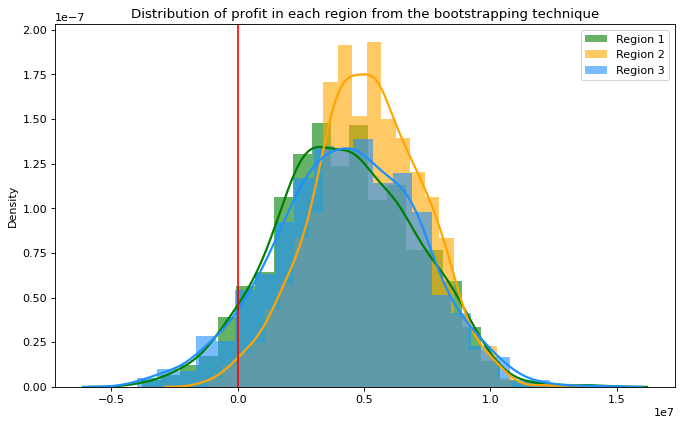

In [25]:
region_1_profit = bootstrapping_revenue(target_valid_0, valid_predictions_0)
region_2_profit = bootstrapping_revenue(target_valid_1, valid_predictions_1)
region_3_profit = bootstrapping_revenue(target_valid_2, valid_predictions_2)

kwargs = dict(hist_kws={'alpha': 0.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,6), dpi= 80)
sns.distplot(region_1_profit, color='green', label='Region 1', **kwargs)
sns.distplot(region_2_profit, color='orange', label='Region 2', **kwargs)
sns.distplot(region_3_profit, color='dodgerblue', label='Region 3', **kwargs)
plt.axvline(0, c="r")
plt.title('Distribution of profit in each region from the bootstrapping technique')
plt.legend();

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you visualized the bootstrapped profit distributions!

</div>

## Final conclusion

I applied the bootstrapping technique to find the distribution of profit and computed the average profit, 95% confidence interval, and risk of losses. From the calculations, it was observed that Region 2 - geo_data_1 has the highest distribution of profit, highest average profit and the lowest risk of losses than any other region. 

Based on this, I can recommend that OilyGiant mining company focus more well development in Region 2 - geo_data_1. Due to Region 2 - geo_data_1 generating the highest average profit, with a risk of losses lower than 2.5%.

In the end I was able to develop a model that can optimize well placement, predict the volume of reserves in new wells, pick the oil wells with the highest estimated reserve, and the region with the highest total profit. This model is useful and will aid in determining whether a production project will be viable and profitable.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent summary!

</div>

Thank you for your time reviewing my project! :)

<div class="alert alert-success">
<b>Reviewer's comment</b>

You're welcome! :)

</div>